In [1]:
%matplotlib notebook
import serial
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
from time import time
from scipy.signal import argrelextrema
from scipy import signal

ser = serial.Serial('COM3', 9600)
# set plot to animated
plt.ion()

In [2]:
Wn = 0.05
b, a = signal.butter(3, Wn)
zi = signal.lfilter_zi(b, a)

<IPython.core.display.Javascript object>


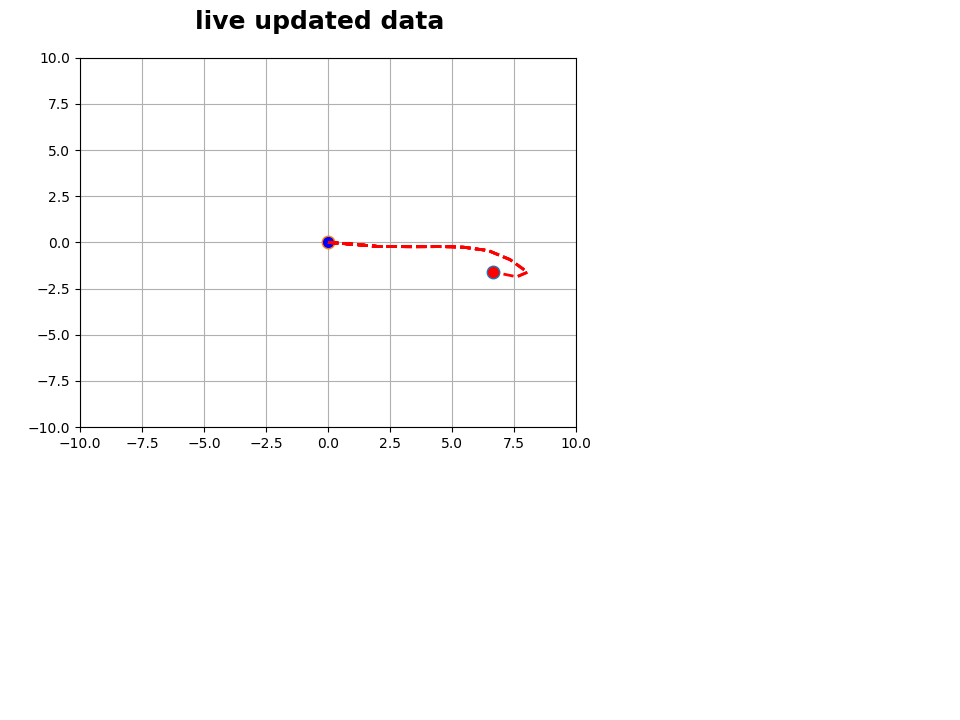

calibrating
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
[5 8]
[  13.88235294 -135.29411765]
[ -2.80000000e+02   2.50000000e-01]
[-58.    -42.375]
calibrating done


In [ ]:
start_time = time()
timepoints = []
accel = [[]for i in range(2)]
accelfor = [[]for i in range(2)]
angle =[[]for i in range(2)]
x = [0,0]
y = [0,0]
mrange = [-10, 10] #map range
yrange = [-180,180]
view_time = 1 # seconds of data to view at once
duration = 90  # total seconds to collect data
ind = [0,0]
# Values to trigger a step and forward movement
steplim = 150
forlim = 100

# Store Location
verts0 = [(0,0)]
verts1 = [(0,0)]

# total steps
totes = [0,0]

fig1 = plt.figure()
fig1.suptitle('live updated data', fontsize='18', fontweight='bold')
#plt.xlabel('time, seconds', fontsize='14', fontstyle='italic')
#plt.ylabel('potential, volts', fontsize='14', fontstyle='italic')
plt.axes().grid(True)
line1, = plt.plot(accel[0],marker='o',markersize=9,linestyle='none',markerfacecolor='red')
line2, = plt.plot(accel[1],marker='o',markersize=9,linestyle='none',markerfacecolor='blue')
ax = fig1.add_subplot(111)
plt.ylim(mrange)
plt.xlim(mrange)

#fig = plt.figure()
#path = Path([(0.,0.)], [Path.MOVETO])
#pathbeg = (0.,0.)
#plt.show

calib_tim = 10#20
# correction offset
accelcor = np.array([0,0])  
accelforcor = np.array([0,0])
anglecor = np.array([0,0])
i = np.array([0,0])
print('calibrating')
while (time() < start_time + calib_tim):
    #just read data to get calibration moving
    ser.reset_input_buffer()
    data = ser.readline()
    
    if (time() > start_time + calib_tim - 2):
        print('do not move')
        data = data.decode().split()
        client = int(data[3])
        anglecor[client] = anglecor[client] + float(data[0])
        accelcor[client] = accelcor[client] + float(data[1])
        accelforcor[client] = accelforcor[client] + float(data[2])
        i[client] = i[client] + 1    

# Average calibration data to find offsets for each transmitter
anglecor = (360/306)*anglecor/i        
accelcor = accelcor/i
accelforcor = accelforcor/i

print(i)
print(anglecor)
print(accelcor)
print(accelforcor)

print('calibrating done')
start_time = time()

run =  True
initial = [0,0] # used to get first dataset

# collect the data and plot a moving frame. When this loop stops, the map stops
while run:
    run2 = True
    #start2 = time()
    startind = ind*1
    #print(time())
    
    iloop = [0,0]
    
    # Loop to get a chunk of data to later process
    while run2:
        
        ser.reset_input_buffer()
        data = ser.readline()
        data = data.decode().split()
        #print(data)

        #reject if data is cut off
        #try:
        #    if (len(data[0]) < 2):
        #        #((len(data[0]) < 2) or (len(data[1]) < 3)):
        #        #(len(data[1]) < 3):
        #        #print('bad val')
        #        #print(data)
        #        continue
        #    #print(data)
        #except IndexError:
        #    continue
        
        try:                      
            # store the entire dataset for later
            client = int(data[3]) # the address of current transmitter data
            #print(client)
            accel[client].append(float(data[1]) - accelcor[client]) #acceleration up/down
            angle[client].append(float(data[0])*360/306 - anglecor[client]) #angle 
            accelfor[client].append(float(data[2]) - accelforcor[client]) # acceleration forward/backward
            
            if initial[client] == 1: # increment loop count after first dataset
                iloop[client] = iloop[client] + 1  
            
            # Get time at end of cycle to know whether to stop outer loop
            if client == 0: 
                timepoints.append(time()-start_time)
                #current_time = timepoints[-1]


            # when time's up, kill the collect loop
            # kill run2 when we gather at least 3 samples from both transmitters
            if timepoints[-1] > duration: run=False
            if (iloop[0] >= 5) & (iloop[1] >= 5): run2 = False

        # if the try statement throws an error, just do nothing
        except: pass
        
        # Record current sample index (depending on current transmitter data)
        if initial[client] == 1 :
            ind[client] = ind[client] + 1
        else: # This is reached after first dataset so change initial to count loops
            initial[client] = 1
        #print(ind)
        #print(startind)
        
    overlap = 1 # frame overlap

    # Acceleration Peaks
    # determine the indices of the local maxima
    for i in range(2):

        if(startind[i] < overlap): #don't begin overlap until we have enough samples to overlap
            overlap = 0
            
        accelframe = np.array(accel[i][startind[i]-overlap:ind[i] + 1])
        accelforframe = np.array(accelfor[i][startind[i]-overlap:ind[i] + 1])
        #print(accelframe)
        maxInd = np.array(argrelextrema(accelframe, np.greater)[0])

        # get the actual values using these indices
        peaks = accelframe[maxInd]  # array([5, 3, 6]) peak moving average accel values
        stepind = np.nonzero(peaks > steplim)[0] # index of local maxima that are higher than 500
        stepsamp = maxInd[stepind]  # index of whole sample vector where step occurs
        peaks = peaks[stepind]      
        stepsize = 0.5 
        step = peaks.shape[0]
        dist = step* stepsize # number of estimated steps times distance of 1 step
        
                
        #if i == 0:
        #    print('Frame 0 accel')
        #    print(accelframe)
        #    print(startind)
        #    print(ind)
        #    print(peaks)
        #    print('last val')
        #    print(accel[i][ind[i]])

        #print(dist)
        #print(cumsum_vec)
        #print('Steps: ' + str(step))
        
        totes[i] = totes[i] + step
    
        # Forward Backward Angle

        # polar to cartesian coordinates
    #    print(stepsamp.shape)
    #    print(stepsamp)
    #    print(type(stepsamp[0]))
    #    print(len(angle))
        for samp in stepsamp:

            # Find whether step was forward/backward or in place
            # forward acceleration at moment of step, we move our bodies 2 samples before we move up
            #stepfor = accelforframe[samp-2] 
            #if (stepfor > forlim): direction = 1 
            #elif (stepfor < -forlim+50): direction = -1
            #else: direction = 0
            direction = 1
            #print(stepfor)
            #print(direction)

            # take angle and find distance for each step
            #print('samp')
            #print(i)
            #print(len(angle[i]))
            #print(samp)
            #print(startind[i])
            #print(samp + startind[i]-overlap)
            anglestep = angle[i][samp + startind[i]-overlap]
            #print('Angle: ' + str(anglestep))
            x[i] = direction*stepsize*np.cos(np.deg2rad(anglestep)) + x[i]
            y[i] = direction*stepsize*np.sin(np.deg2rad(anglestep)) + y[i]

        #print('%f %f'%(x,y))
        line1.set_xdata(x[0])
        line1.set_ydata(y[0])
        line2.set_xdata(x[1])
        line2.set_ydata(y[1])
        #fig1.canvas.draw()
    #print('-----')
    #print(x[1])
    #print('--x--')
    verts0.append((x[0],y[0]))
    xs, ys = zip(*verts0)
    ax.plot(xs, ys, '--', lw=2, color='red', ms=10)
    
    verts1.append((x[1],y[1]))
    xs, ys = zip(*verts1)
    ax.plot(xs, ys, '--', lw=2, color='blue', ms=10)
    fig1.canvas.draw()


print('client 0')
print(totes[0])
print('client 1')
print(totes[1])
fig2 = plt.figure()
fig2.suptitle('Angle complete data trace', fontsize='18', fontweight='bold')
plt.xlabel('time, seconds', fontsize='14', fontstyle='italic')
plt.ylabel('Angle', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

plt.plot(timepoints, angle[0],marker='o',markersize=4,linestyle='none',markerfacecolor='red')
plt.ylim(yrange)
fig2.show()

plt.figure()
plt.plot(accel[0])
plt.title('Up/Down Acceleration Transmitter 0')
plt.figure()
plt.plot(accel[1])
plt.title('Up/Down Acceleration Transmitter 1')

plt.figure()
window_width = 10
z, _ = signal.lfilter(b, a, accel[0], zi=zi*accel[0][0])
                                      
cumsum_vec = np.cumsum(np.insert(accel[0], 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)


# determine the indices of the local maxima
maxInd = np.array(argrelextrema(ma_vec, np.greater)[0])

# get the actual values using these indices
r = ma_vec[maxInd]  # array([5, 3, 6])
stepind = np.nonzero(r > steplim)[0] # index of local maxima that are higher than 500
stepsamp = maxInd[stepind]
r = r[stepind]
stepsize = 0.5 
step = r.shape[0]
disp = np.sqrt(x[0]**2+y[0]**2) # number of estimated steps times distance of 1 step
print('Total steps: ' + str(step))
print('Total displacement: ' + str(disp))

plt.figure()
plt.title('Forward/Backward Acceleration')
plt.plot(accelfor[0])
#plt.figure()
#window_width = 10

#cumsum_vec = np.cumsum(np.insert(accelfor, 0, 0)) 
#ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
#plt.plot(ma_vec)


#ser.close()

In [4]:
ser.close()

In [8]:
accel[0][39]

-4135.8571428571431